Problem Statement:
<br>
Yulu is India’s leading micro-mobility service provider, which offers unique vehicles for the daily commute.
<br>
They have provided their data to check how can we increase revenue.
<br>
We need to find the correlation between independent variable and dependent variable, and report whcih factors affect the most in bike rentals.
<br>
For this we will do some visual analysis, and to back those visual analysis with rigorous math we will also do some statistical hypothesis testing to find how the bike rent is affected by different independent features.

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy import stats
import itertools
import math
import statsmodels.api as sm
from scipy.stats import anderson, shapiro

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Dataset exploration

In [3]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Scaler Case Studies/4.YuluBikes/yulu_bikes.csv')

print(df.columns, '\n\n')
print('Shape of the dataset', df.shape, '\n\n')
display(df.head())

Index(['Unnamed: 0', 'datetime', 'season', 'holiday', 'workingday', 'weather',
       'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered',
       'count'],
      dtype='object') 


Shape of the dataset (10886, 13) 




,Unnamed: 0,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
# Dropping column Unnamed: 0, as it is just a row count column, not needed for further analysis
df.drop(columns=['Unnamed: 0'], inplace=True)

display(df.describe())

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [5]:
# Every variable seems to be by default integer or float
# Except for the date & time column
display(df.dtypes)

# let's change the column datetime type to the data type -> datetime 
# df['datetime'] = pd.to_datetime(df['datetime'])
df['datetime'] = df['datetime'].astype('datetime64')

# after converting we can see that the data type is now datetime
print()
print(df['datetime'].dtypes)

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object


datetime64[ns]


#### Feature engineering

In [6]:
# Creating year, month, day, weekday, time_of_day fields from datetime field
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month_name()
df['day'] = df['datetime'].dt.day
df['weekday'] = df['datetime'].dt.day_name()
df['hours'] = df['datetime'].dt.hour

In [7]:
# Checking for missing data and nulls
print('We dont have any missing data')
df.isna().sum()

We dont have any missing data


datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
year          0
month         0
day           0
weekday       0
hours         0
dtype: int64

separating categorical and numerical columns

---


From the below we see that columns (season, holiday, workingday, weather) can be considered as categorical columns, datetime columns is ordinal, other columns can be numerical.

In [8]:
for col in df.columns:
    print(col, df[col].nunique())

datetime 10886
season 4
holiday 2
workingday 2
weather 4
temp 49
atemp 60
humidity 89
windspeed 28
casual 309
registered 731
count 822
year 2
month 12
day 19
weekday 7
hours 24


In [9]:
categorical_cols = ['season', 'holiday', 'workingday', 'weather', 'year', 'month', 'day', 'weekday', 'hours']
numerical_cols = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']

In [10]:
for i in categorical_cols:
    display(df[i].value_counts().sort_values()) 
    print()

1    2686
2    2733
3    2733
4    2734
Name: season, dtype: int64

1      311
0    10575
Name: holiday, dtype: int64

0    3474
1    7412
Name: workingday, dtype: int64

4       1
3     859
2    2834
1    7192
Name: weather, dtype: int64

2011    5422
2012    5464
Name: year, dtype: int64

January      884
February     901
March        901
April        909
September    909
October      911
November     911
May          912
June         912
July         912
August       912
December     912
Name: month, dtype: int64

18    563
11    568
10    572
6     572
3     573
12    573
2     573
4     574
7     574
8     574
13    574
14    574
15    574
16    574
19    574
5     575
17    575
9     575
1     575
Name: day, dtype: int64

Friday       1529
Tuesday      1539
Monday       1551
Wednesday    1551
Thursday     1553
Sunday       1579
Saturday     1584
Name: weekday, dtype: int64

3     433
4     442
2     448
5     452
1     454
0     455
6     455
7     455
8     455
9     455
10    455
11    455
12    456
15    456
16    456
17    456
18    456
19    456
20    456
21    456
22    456
13    456
14    456
23    456
Name: hours, dtype: int64

In [11]:
# From the above analysis we saw that weather type 4 has only one record in the whole dataset 
# So it is safe to assume that it is a typo, we can replace this one data point with the mode of the waether which is type "1"
weather_mode = df['weather'].mode()
df.loc[df['weather']==4, 'weather'] = 1

display(df['weather'].value_counts().sort_values()) 

3     859
2    2834
1    7193
Name: weather, dtype: int64

In [12]:
# We see that season is just the quarters of the year
df[['season', 'month']].groupby(['season'])['month'].unique()

season
1       [January, February, March]
2               [April, May, June]
3        [July, August, September]
4    [October, November, December]
Name: month, dtype: object

## Univariate analysis and Outlier detection

#### Numerical Univariate analysis

Utility functions for Normality Check

In [13]:
# Shapiro-Wilk Test
def shapiroWilk_test(data):
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')


# Anderson-Darling Test
def andersonDarling_test(data):
    result = anderson(data)
    print('Statistic: %.3f' % result.statistic)
    p = 0
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

1) Temperature
   <br>
   From the below figures we can see that there are no outliers, however QQ plot has a lot of points away. Also testing with Shapiro_Wilk_test
Anderson_Darling_test shows that this is not Normal.

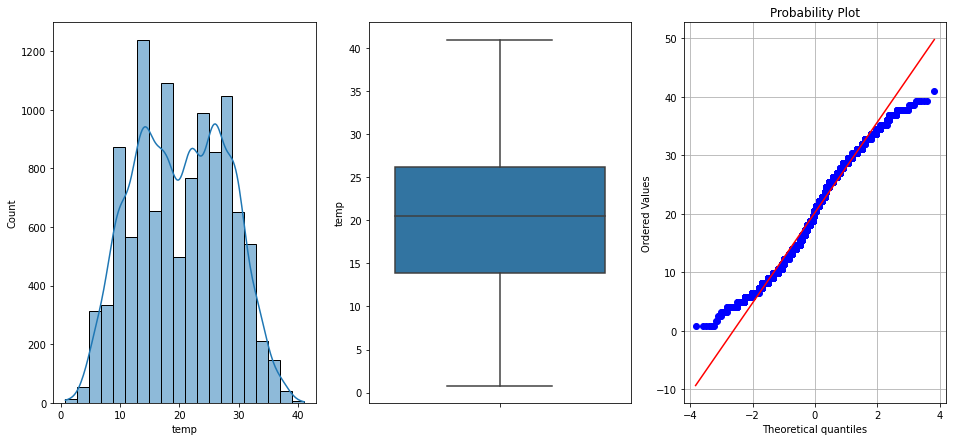




Statistics=0.980, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 26.483
15.000: 0.575, data does not look normal (reject H0)
10.000: 0.655, data does not look normal (reject H0)
5.000: 0.786, data does not look normal (reject H0)
2.500: 0.917, data does not look normal (reject H0)
1.000: 1.091, data does not look normal (reject H0)


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [14]:
fig, ax = plt.subplots(1, 3, figsize=(16,7))
sns.histplot(x=df['temp'], bins=20, kde=True, ax=ax[0])
sns.boxplot(y=df['temp'], ax=ax[1])

# qqplot
stats.probplot(df['temp'], dist=stats.norm,  fit=False, plot=ax[2])

plt.grid()
plt.show()

print('\n\n')
shapiroWilk_test(df['temp'])
andersonDarling_test(df['temp'].sample(n=4000))

2) Feeling Temperature
   <br>
   From the below figures we can see that there are no outliers, however QQ plot has a lot of points away. So it is not normal.

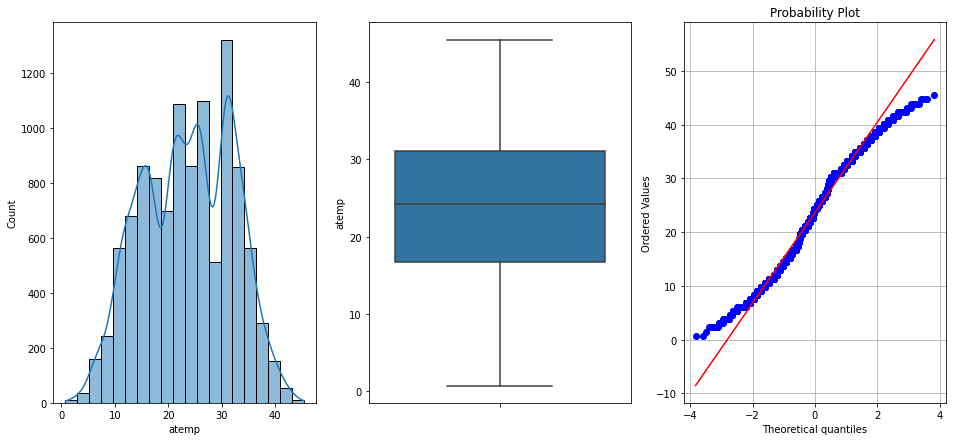




Statistics=0.982, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 24.193
15.000: 0.575, data does not look normal (reject H0)
10.000: 0.655, data does not look normal (reject H0)
5.000: 0.786, data does not look normal (reject H0)
2.500: 0.917, data does not look normal (reject H0)
1.000: 1.091, data does not look normal (reject H0)


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [15]:
fig, ax = plt.subplots(1, 3, figsize=(16,7))
sns.histplot(x=df['atemp'], bins=20, kde=True, ax=ax[0])
sns.boxplot(y=df['atemp'], ax=ax[1])


# qqplot
stats.probplot(df['atemp'], dist=stats.norm,  fit=False, plot=ax[2])

plt.grid()
plt.show()

print('\n\n')
shapiroWilk_test(df['atemp'])
andersonDarling_test(df['atemp'].sample(n=4000))

3) Humidity
<br>
It is left skewed. We also have some left outliers. However the outliers convey some meaning as values 0 to 20 for humidity is possible. So we are not removing the outliers.

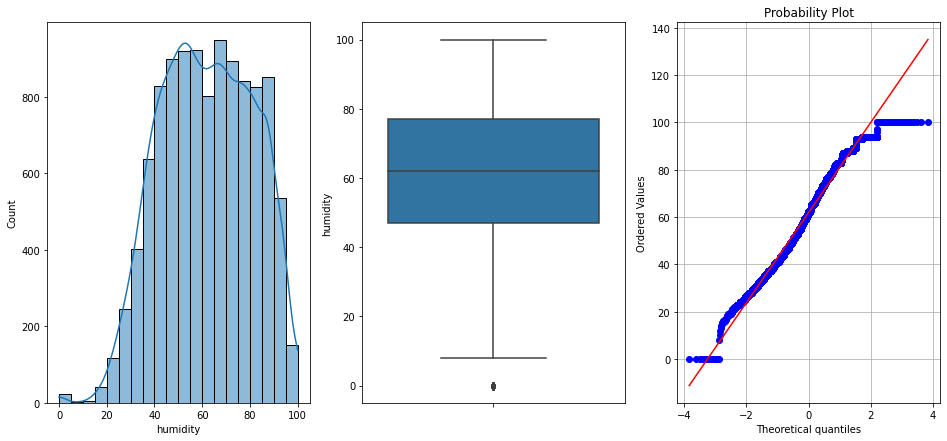




Statistics=0.982, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 20.546
15.000: 0.575, data does not look normal (reject H0)
10.000: 0.655, data does not look normal (reject H0)
5.000: 0.786, data does not look normal (reject H0)
2.500: 0.917, data does not look normal (reject H0)
1.000: 1.091, data does not look normal (reject H0)


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [16]:
fig, ax = plt.subplots(1, 3, figsize=(16,7))
sns.histplot(x=df['humidity'], bins=20, kde=True, ax=ax[0])
sns.boxplot(y=df['humidity'], ax=ax[1])

# qqplot
stats.probplot(df['humidity'], dist=stats.norm,  fit=False, plot=ax[2])

plt.grid()
plt.show()

print('\n\n')
shapiroWilk_test(df['humidity'])
andersonDarling_test(df['humidity'].sample(n=4000))

4) Windspeed
<br>
Clearly right skewed, we will handle these below.

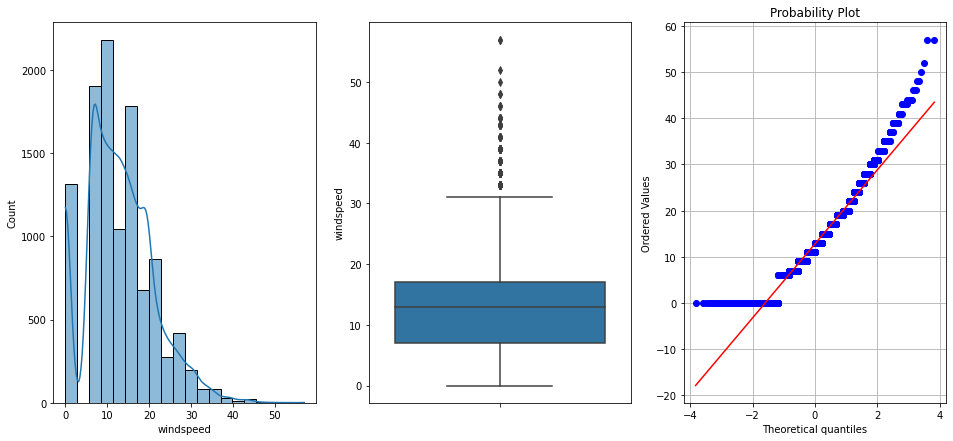




Statistics=0.959, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 37.245
15.000: 0.575, data does not look normal (reject H0)
10.000: 0.655, data does not look normal (reject H0)
5.000: 0.786, data does not look normal (reject H0)
2.500: 0.917, data does not look normal (reject H0)
1.000: 1.091, data does not look normal (reject H0)


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [17]:
fig, ax = plt.subplots(1, 3, figsize=(16,7))
sns.histplot(x=df['windspeed'], bins=20, kde=True, ax=ax[0])
sns.boxplot(y=df['windspeed'], ax=ax[1])

# qqplot
stats.probplot(df['windspeed'], dist=stats.norm,  fit=False, plot=ax[2])

plt.grid()
plt.show()


print('\n\n')
shapiroWilk_test(df['windspeed'])
andersonDarling_test(df['windspeed'].sample(n=4000))

In [18]:
# # On analyzing these 227 outliers we found that these values are high, 
# # so we will replace these with median

# # NOTE: We are not removing these records because they could contribute to other analysis as well

# q75, q25 = np.percentile(df['windspeed'], [75 ,25])

# print('Shape of outliers', df[ df['windspeed'] > (q75+(1.5*(q75-q25))) ].shape)
# print('\n\n')

# df.loc[df['windspeed'] > (q75+(1.5*(q75-q25))), 'windspeed']  = np.median(df['windspeed'])

In [19]:
# fig, ax = plt.subplots(1, 3, figsize=(16,7))
# sns.histplot(x=df['windspeed'], bins=20, kde=True, ax=ax[0])
# sns.boxplot(y=df['windspeed'], ax=ax[1])

# # qqplot
# stats.probplot(df['windspeed'], dist=stats.norm,  fit=False, plot=ax[2])

# plt.grid()
# plt.show()


# print('\n\n')
# shapiroWilk_test(df['windspeed'])
# andersonDarling_test(df['windspeed'].sample(n=4000))

5) Casual Users
<br>
This is right skewed. So we wil use log transform to get rid of outliers.

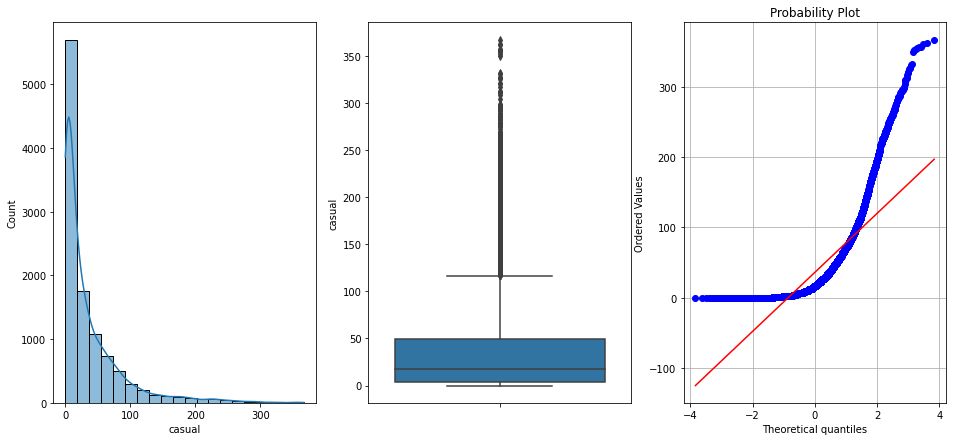

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(16,7))
sns.histplot(x=df['casual'], bins=20, kde=True, ax=ax[0])
sns.boxplot(y=df['casual'], ax=ax[1])

# qqplot
stats.probplot(df['casual'], dist=stats.norm,  fit=False, plot=ax[2])

plt.grid()
plt.show()

In [21]:
# df['casual'] = np.log(df['casual'])

# fig, ax = plt.subplots(1, 3, figsize=(16,7))
# sns.histplot(x=df['casual'], bins=20, kde=True, ax=ax[0])
# sns.boxplot(y=df['casual'], ax=ax[1])

# # qqplot
# stats.probplot(df['casual'], dist=stats.norm,  fit=False, plot=ax[2])

# plt.grid()
# plt.show()

6) Registered
<br>
Again right skewed, So we will use log transform.

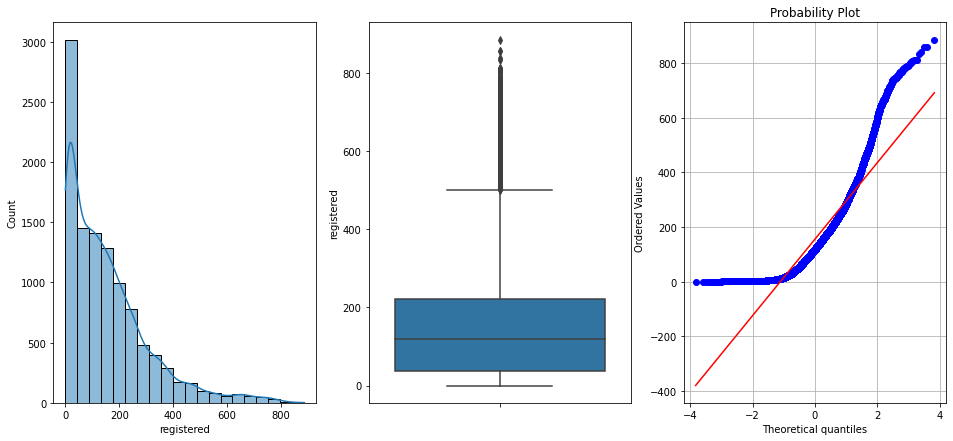

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(16,7))
sns.histplot(x=df['registered'], bins=20, kde=True, ax=ax[0])
sns.boxplot(y=df['registered'], ax=ax[1])

# qqplot
stats.probplot(df['registered'], dist=stats.norm,  fit=False, plot=ax[2])

plt.grid()
plt.show()

In [23]:
# df['registered'] = np.log(df['registered'])

# fig, ax = plt.subplots(1, 3, figsize=(16,7))
# sns.histplot(x=df['registered'], bins=20, kde=True, ax=ax[0])
# sns.boxplot(y=df['registered'], ax=ax[1])

# # qqplot
# stats.probplot(df['registered'], dist=stats.norm,  fit=False, plot=ax[2])

# plt.grid()
# plt.show()

7) Count = Casual Users + Registered Users.
<br>
As both the features Casual users + Registered users are summed to get Count. So it will also be right skewed. As usual we will do log transform for this.

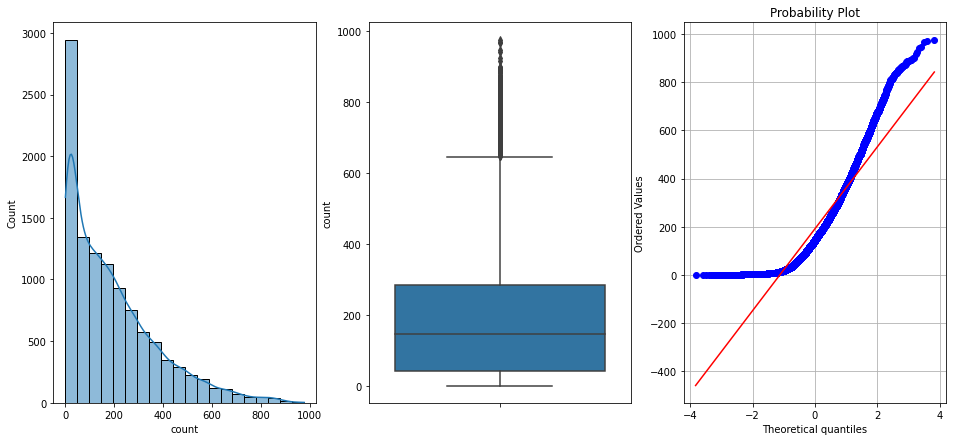

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(16,7))
sns.histplot(x=df['count'], bins=20, kde=True, ax=ax[0])
sns.boxplot(y=df['count'], ax=ax[1])

# qqplot
stats.probplot(df['count'], dist=stats.norm,  fit=False, plot=ax[2])

plt.grid()
plt.show()

In [25]:
# df['count'] = np.log(df['count'])

# fig, ax = plt.subplots(1, 3, figsize=(16,7))
# sns.histplot(x=df['count'], bins=20, kde=True, ax=ax[0])
# sns.boxplot(y=df['count'], ax=ax[1])

# # qqplot
# stats.probplot(df['count'], dist=stats.norm,  fit=False, plot=ax[2])

# plt.grid()
# plt.show()

#### Categorical Univariate Analysis

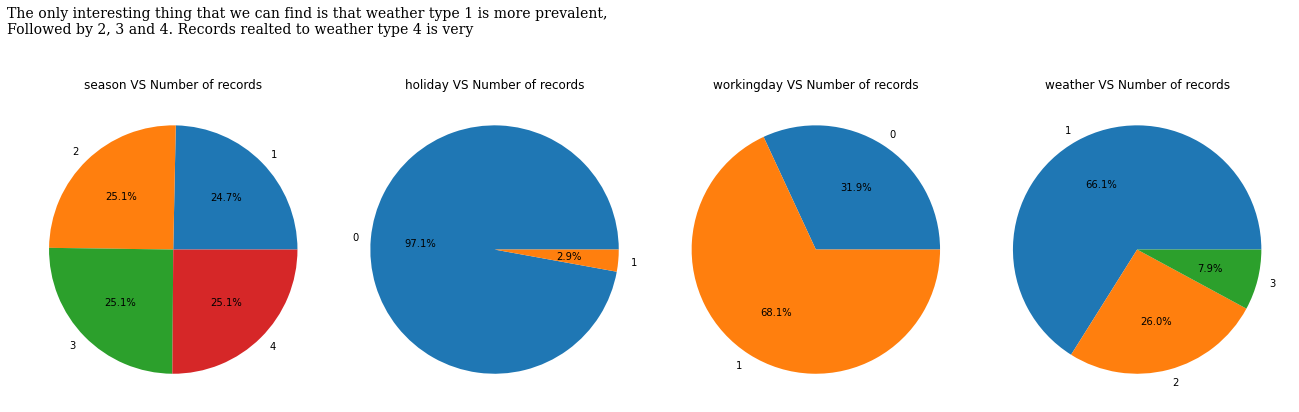

In [26]:
fig, ax = plt.subplots(1,4, figsize=(18,6))

for i, col in enumerate(['season', 'holiday', 'workingday', 'weather']):
    new_df = df[[col]].reset_index().groupby(col)['index'].count().reset_index()
    ax[i%4].pie(new_df['index'], labels=new_df[col], autopct='%.1f%%')
    ax[i%4].set_title(col + ' VS Number of records')


observation = '''The only interesting thing that we can find is that weather type 1 is more prevalent,
Followed by 2, 3 and 4. Records realted to weather type 4 is very'''
fig.text(0, 1, observation, fontsize=14, fontweight='light', fontfamily='serif')
plt.tight_layout()
plt.show()

## Bivariate Analysis

#### Categorical VS Numerical

All the categorical variables VS Count of bikes rent

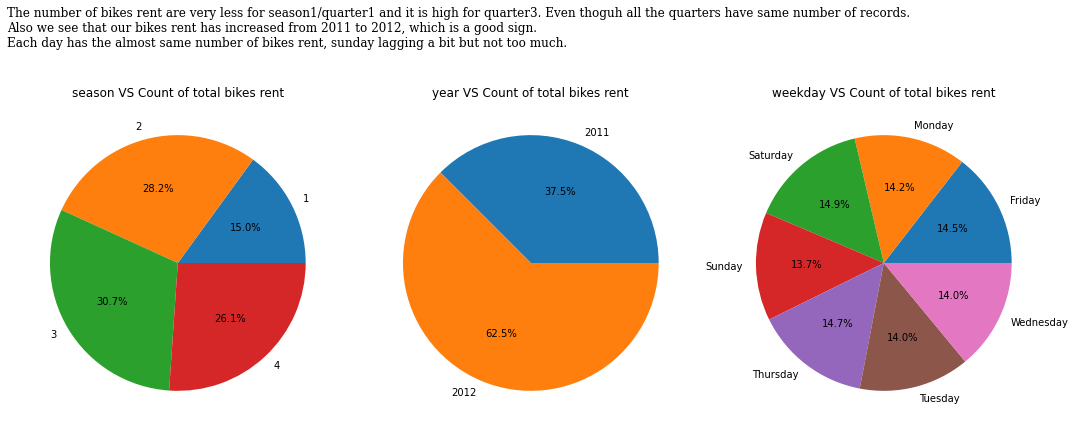

In [27]:
fig, ax = plt.subplots(1,3, figsize=(15,6))

for i, col in enumerate(['season', 'year', 'weekday']):
    new_df = df[[col, 'count']].reset_index().groupby(col)['count'].sum().reset_index()
    ax[i%3].pie(new_df['count'], labels=new_df[col], autopct='%.1f%%')
    ax[i%3].set_title(col + ' VS Count of total bikes rent')


observation = '''The number of bikes rent are very less for season1/quarter1 and it is high for quarter3. Even thoguh all the quarters have same number of records.
Also we see that our bikes rent has increased from 2011 to 2012, which is a good sign.
Each day has the almost same number of bikes rent, sunday lagging a bit but not too much.'''
fig.text(0, 1, observation, fontsize=12, fontweight='light', fontfamily='serif')
plt.tight_layout()
plt.show()

Obervations:

1. fig1: Season3 has the highest mean bike rentals, followed by season2, season4. Season1 has the lowest.
<br>
<br>
2. fig2: June has the higest bike rentals, followed by july, august, september. Also we see that the rentals increase from Jan to June, decrease from september to december. Jan has the lowest rentals as comapred to others.
<br>
<br>
3. fig3: Weather1 is suitable may be neutral weather, so this has high rentals. Weather2 is Cloudy+Mist, weather3 is the worst Thunderstorm.
<br>
<br>
4. fig4: Interestingly workingday and non workingday has alomst the same mean of bike rentals, however in the below analaysis we see that based on the time of a particular day the bike rentals vary for working and non working day.
<br>
<br>
5. fig5: Friday has the highest mean rentals, followed by saturday, thursday, Sunday has the lowest rentals.
<br>
<br>
6. fig6: The avg bike rentals actually decreases if it is holiday.

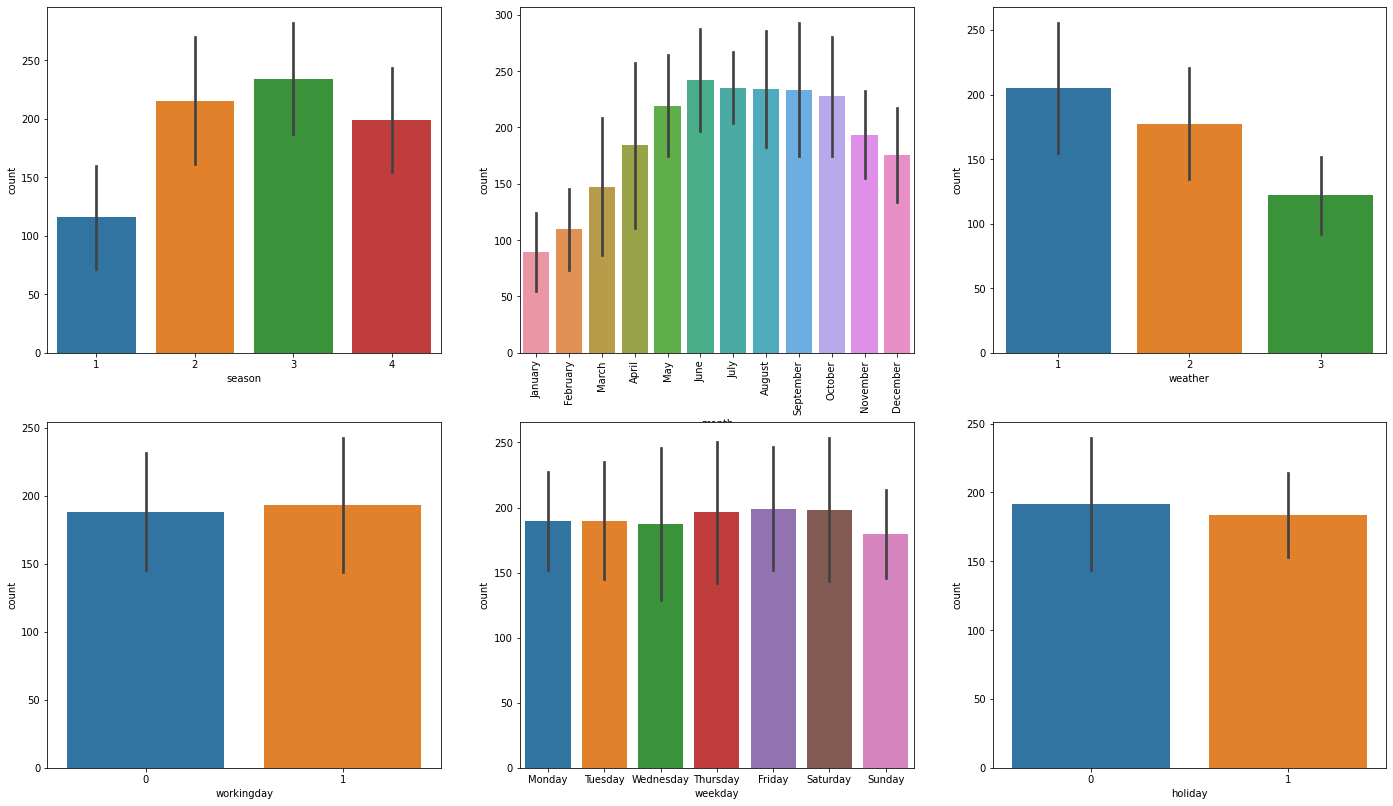

In [28]:
# We that we have season1 - 4 from 2 years, So we will take the count of each season for each year, then we will do our analysis on top of that, similar approach will be follwed for other categorical variables as well
fig, ax = plt.subplots(2,3, figsize=(24,14))

season_df = df[['year', 'season', 'count']].groupby(['season', 'year']).mean('count').sort_values(['season']).reset_index()
sns.barplot(data=season_df, x='season', y='count', ax=ax[0][0])


month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
month_df = df[['year', 'month', 'count']].groupby(['month', 'year']).mean('count').reset_index()
month_df['month'] = pd.Categorical(month_df['month'], categories=month_order, ordered=True)
month_df = month_df.sort_values('month')
sns.barplot(data=month_df, x='month', y='count', ax=ax[0][1])
ax[0][1].xaxis.set_tick_params(rotation=90)


season_df = df[['year', 'weather', 'count']].groupby(['weather', 'year']).mean('count').sort_values(['weather']).reset_index()
sns.barplot(data=season_df, x='weather', y='count', ax=ax[0][2])


season_df = df[['year', 'workingday', 'count']].groupby(['workingday', 'year']).mean('count').sort_values(['workingday']).reset_index()
sns.barplot(data=season_df, x='workingday', y='count', ax=ax[1][0])


weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
season_df = df[['year', 'weekday', 'count']].groupby(['weekday', 'year']).mean('count').reset_index()
season_df['weekday'] = pd.Categorical(season_df['weekday'], categories=weekday_order, ordered=True)
season_df = season_df.sort_values(['weekday'])
sns.barplot(data=season_df, x='weekday', y='count', ax=ax[1][1])


season_df = df[['year', 'holiday', 'count']].groupby(['holiday', 'year']).mean('count').sort_values(['holiday']).reset_index()
sns.barplot(data=season_df, x='holiday', y='count', ax=ax[1][2])


plt.show()


#### Numerical VS Numerical

Observations:
<br>
<br>
1. fig1: Temp and Atemp are +vely correlated. If we do analysis for Temp with other variables, then Atemp will also follow the same trend as Temp.
<br>
<br>
2. fig2: Most of the bikes are rented when humidity is in the range 30 to 60.
<br>
<br> 
3. fig3: Most of the bikes are rented when temp is in the range 15 to 30, which is expected as normal temp varies in this range.
<br>
<br>
4. fig4: Most of the times windspeed is zero, also bike rent decreases heavily when windspeed is more than 20.

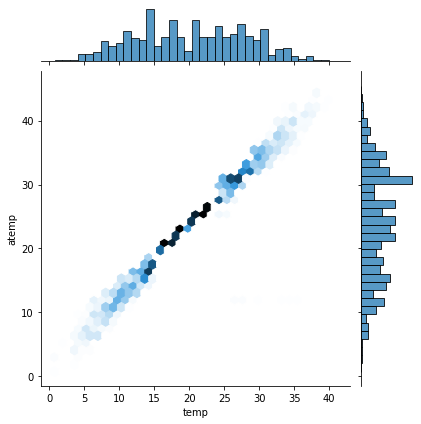

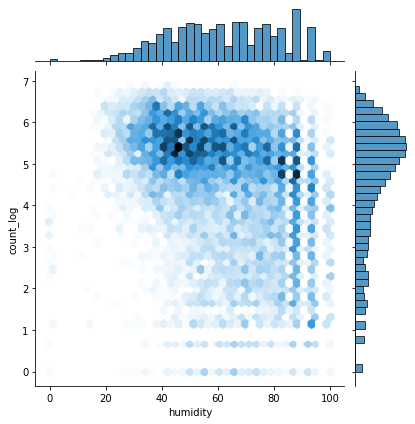

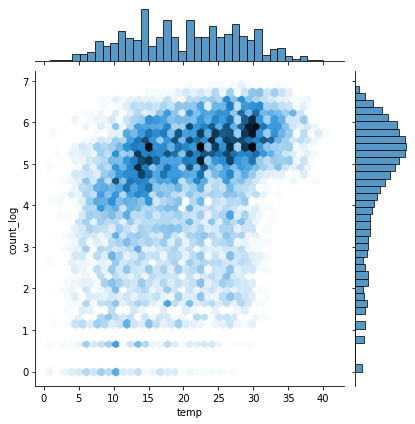

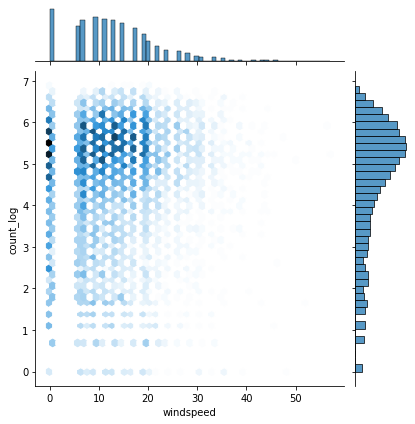

In [29]:
# Inorder to visualize numerical plots properly we will first transform the count feature to logarithmic scale
df['count_log'] = np.log(df['count'])


x_col, y_col = 'temp', 'atemp'
sns.jointplot(data=df, x=x_col, y=y_col, kind='hex')
plt.show()
print('\n\n')


x_col, y_col = 'humidity', 'count_log'
sns.jointplot(data=df, x=x_col, y=y_col, kind='hex')
plt.show()
print('\n\n')


x_col, y_col = 'temp', 'count_log'
sns.jointplot(data=df, x=x_col, y=y_col, kind='hex')
plt.show()
print('\n\n')


x_col, y_col = 'windspeed', 'count_log'
sns.jointplot(data=df, x=x_col, y=y_col, kind='hex')
plt.show()
print('\n\n')

There is a trend that bike rentals follow. In both the years, the rental mean increases till the half of the year(i.e. till june, july), then it decreses.
With one exception 2012 july has less rentals than june.

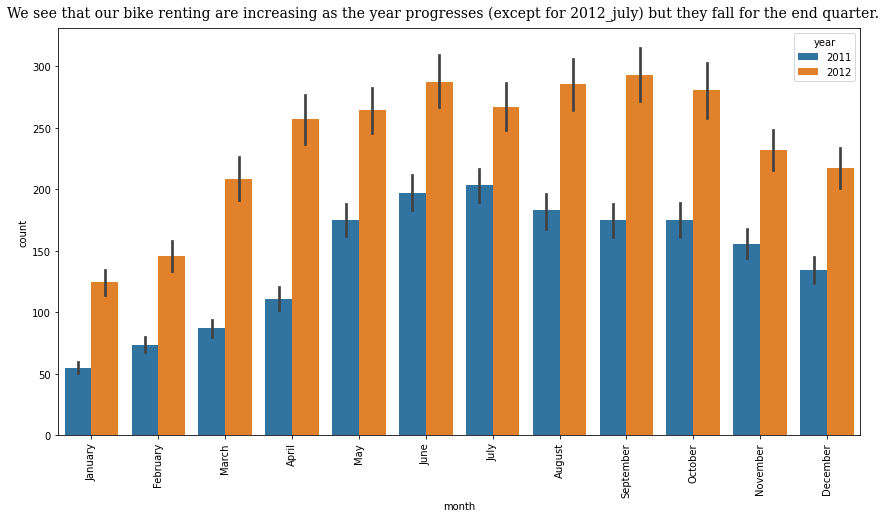

In [30]:
# Analyzing weather why the sells have been low in quarter1

fig, ax = plt.subplots(1, 1, figsize=(12,7))
sns.barplot(data=df, x='month', y='count', hue='year', ax=ax)

ax.xaxis.set_tick_params(rotation=90)


observation = '''We see that our bike renting are increasing as the year progresses (except for 2012_july) but they fall for the end quarter.'''
fig.text(0, 1, observation, fontsize=14, fontweight='light', fontfamily='serif')
plt.tight_layout()
plt.show()

## Multivariate Analysis

Hours VS MeanUserCount for different Seasons, Weekday, Workingday, Holiday, Weather
<br>
<br>

Few observations from these plots that we can find are:
<br>
1. 1st fig: Season3(Quarter3) has the highest sales on any of the season, Season1(Quarter1) has the lowest sales.
<br>
<br>
2. 2nd fig: For weakdays there are clear peaks at time 7-8 AM and 5-7 PM. 
However for weekends the number of bike rent starts increasing at 8AM, and almost stsys at the peak from 12-3 PM. Because in weekends people generally go out in these time periods. 
<br>
<br>
3. 3rd fig: From 9.30AM to 4PM and 12AM to 3AM weekends have more bike rents than weekdays. Because people go out shppoing during these morning hours and night outings are more common in weekends so 12AM to 3AM has more bike rents than weekdays.
<br>
<br>
4. 4th fig: Weather type 3 has the less mean bike rents as compared to others. 
Weather1 overall has majority of the day's mean greater than Weather2.
<br>
<br>
5. 5th fig: Holidays has the less bike rents as comapred to normal days, except from the time 9.30AM to 4PM, It follows the same trend as weekdays vs weekends.

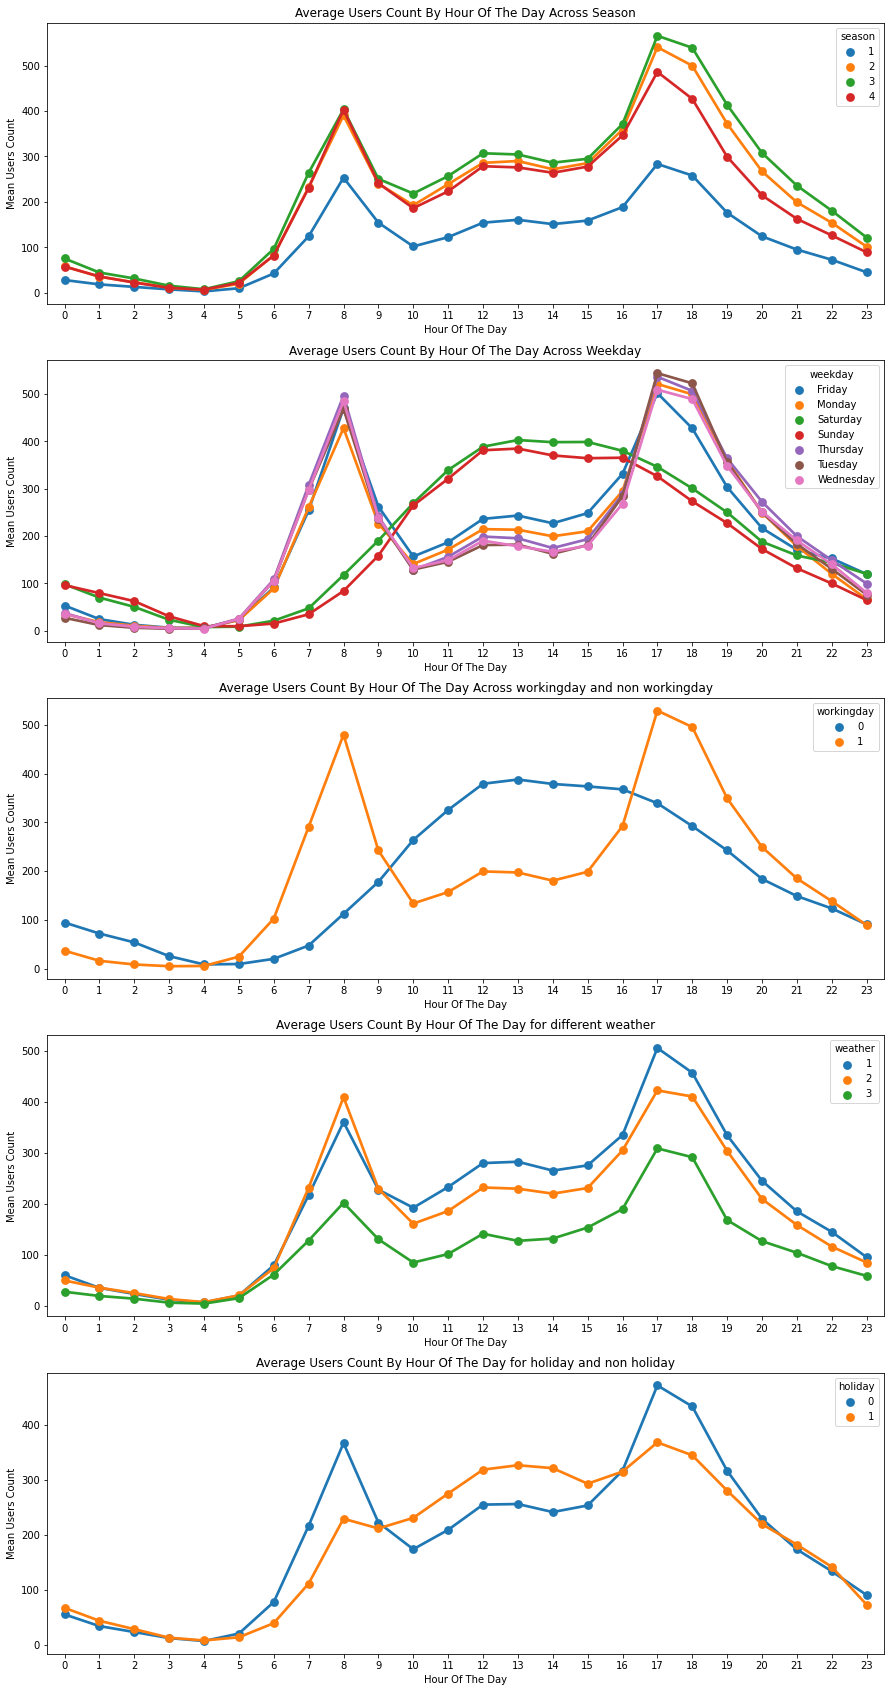

In [31]:
fig, ax = plt.subplots(5, 1, figsize=(15,30))

# Hour VS Count for different Seasons
hourAggregated = pd.DataFrame(df.groupby(["hours","season"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hours"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax[0])
ax[0].set(xlabel='Hour Of The Day', ylabel='Mean Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')


# Hour VS Count for different Weekday
hourAggregated = pd.DataFrame(df.groupby(["hours","weekday"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hours"], y=hourAggregated["count"],hue=hourAggregated["weekday"], data=hourAggregated, join=True,ax=ax[1])
ax[1].set(xlabel='Hour Of The Day', ylabel='Mean Users Count',title="Average Users Count By Hour Of The Day Across Weekday",label='big')


# Hour VS Count for different Workingday
hourAggregated = pd.DataFrame(df.groupby(["hours","workingday"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hours"], y=hourAggregated["count"],hue=hourAggregated["workingday"], data=hourAggregated, join=True,ax=ax[2])
ax[2].set(xlabel='Hour Of The Day', ylabel='Mean Users Count',title="Average Users Count By Hour Of The Day Across workingday and non workingday",label='big')


# Hour VS Count for different Workingday
hourAggregated = pd.DataFrame(df.groupby(["hours","weather"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hours"], y=hourAggregated["count"],hue=hourAggregated["weather"], data=hourAggregated, join=True,ax=ax[3])
ax[3].set(xlabel='Hour Of The Day', ylabel='Mean Users Count',title="Average Users Count By Hour Of The Day for different weather",label='big')


# Hour VS Count for different holiday
hourAggregated = pd.DataFrame(df.groupby(["hours","holiday"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hours"], y=hourAggregated["count"],hue=hourAggregated["holiday"], data=hourAggregated, join=True,ax=ax[4])
ax[4].set(xlabel='Hour Of The Day', ylabel='Mean Users Count',title="Average Users Count By Hour Of The Day for holiday and non holiday",label='big')

plt.show()

#### Corrleation plot

Observations:
<br>
1. We see that casual and registerd are higly correlated with count, because count is just the summation of these 2 features.
2. Temp and Atemp(feeling temp) are highly correlated with corr factor 0.98.
3. Also Temp and Atemp are higly +ve correlated with count with corr factor almost 0.4. Means people usually like to go bike when temp is high.
4. However the humidity is higly -ve correlated with count with corr factor -0.32. When humidity is low people like to bike more.

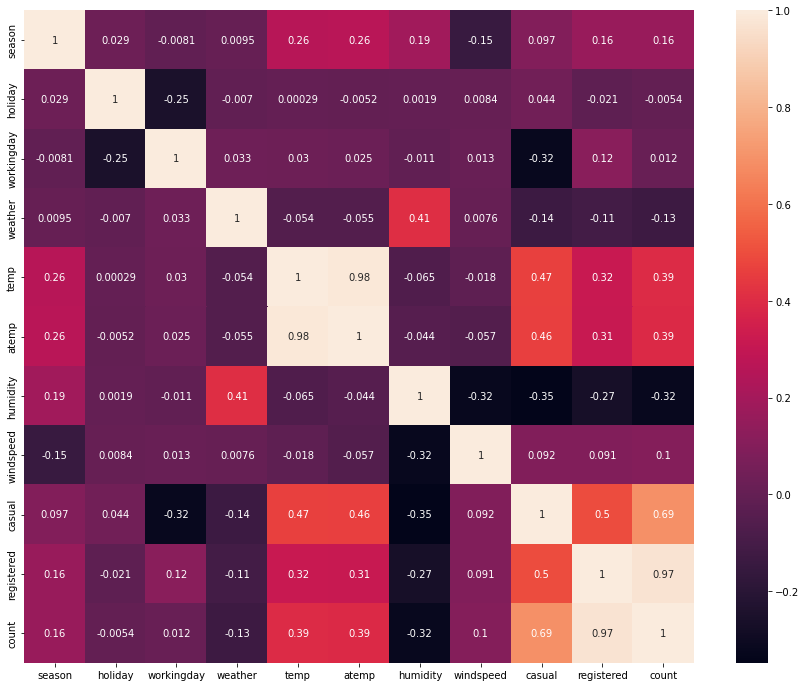

In [65]:
columns_for_correlation = ['season', 'holiday', 'workingday', 'weather', 'temp',
                           'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']

fig, ax = plt.subplots(1, 1, figsize=(15,12))
sns.heatmap(df[columns_for_correlation].corr(), annot=True)

## Hypothesis testing

### 2 sample Independent T test to check whether workingday has any effect on the dependent variable, count.


Note: 
<br>
Here we have choosen (Q3 + 1.4IQR) to remove outliers (after few trials and errors) which helps in KS test, 
<br>
As KS test is comparison od CDFS if we remove some outliers, we cn actually see a P-val of  0.07, which is greater than 0.05.

---
Assumptions:

1) Are the two samples independent? 
<br>
Yes because rental of bike on working day does not depend on non working day, samples are independent.
<br>
<br>
2) Are the data from each of the 2 groups following a normal distribution?
<br>
From the below Shapario Wilk's test fails as P val is very less than 0.05.
<br>
Still we will go ahead with our approach (because it was mentioned in the problem statement).
<br>
However if we plot histograms and QQ plot our 2 samples look close to normal distribution. The CDF also shows both the plots are kind of similar.
<br>
<br>
3) Do the two samples have the same variances (Homogeneity of Variance)?
<br>
Levene test also fails with a P-val of 0.001 which is lower than 0.05.

---
Null Hypothesis (H0): Mean of workingday sample = Mean of non working day sample
<br>
Alternate Hypothesis (Ha): Mean of workingday sample <> Mean of non working day sample (can be < or >)
<br>

From the above hypothesis we can say that this is a 2 tailed distribution.

For 2 tailed distribution with significance level of 0.05 and degrees of freedom that we choose to be  (100+100-2) = 198, T-critical value lies in between -1.97 to +1.97, And our test statistics gave us T-statistic=-0.69.
<br>
<br>
<br>

Conclusion:
<br>
As T-statistics lies in between -ve T-critical to +ve T-critical with 95% CI we can say that the bike rental for workingday and non workingday are same.

Difference in shapes between original df and after removing outliers:  363
Shapiro Wilk test for normality check for sample1, gives test_statistics and p_val of: (0.934028685092926, 8.487947343382984e-05)
Shapiro Wilk test for normality check for sample2, gives test_statistics and p_val of: (0.9609997272491455, 0.004741454962641001)
LeveneResult(statistic=10.77441160998119, pvalue=0.0012164859440098386)





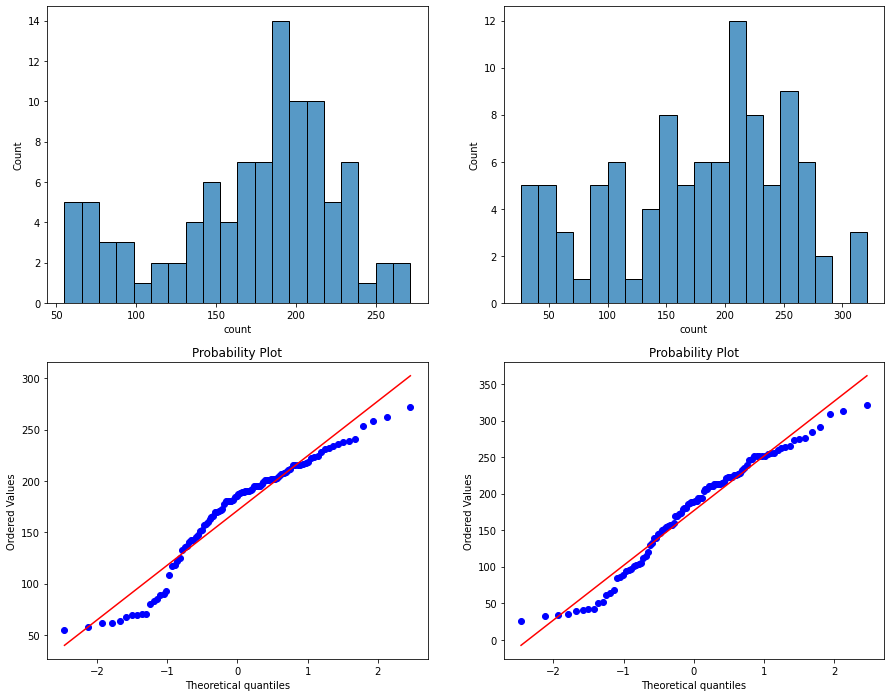

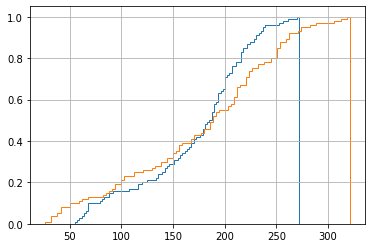

In [32]:
from scipy import stats


# Here we will remove points above  (Q3 + 1.4*IQR) as outliers
q75, q25 = np.percentile(df['count'], [75 ,25])
new_df = df[df['count']<(q75+(1.4*(q75-q25)))]
print('Difference in shapes between original df and after removing outliers: ', df.shape[0] - new_df.shape[0])


# In the original df we have data granularity on the time level, but to peform this task we need data on the day granular level
# the below transform gets the data in the day granular level
workingday_df = new_df[['year', 'month', 'day', 'workingday', 'count']].groupby(['year', 'month', 'day', 'workingday']).mean('count').reset_index()

random_state = 42

# Our sample1 is working day sample, sample2 is non workingday sample
sample1 = workingday_df[workingday_df['workingday']==1]['count'].sample(n=100, random_state=random_state)
sample2 = workingday_df[workingday_df['workingday']==0]['count'].sample(n=100, random_state=random_state)

print(f"Shapiro Wilk test for normality check for sample1, gives test_statistics and p_val of: {stats.shapiro(sample1)}")
print(f"Shapiro Wilk test for normality check for sample2, gives test_statistics and p_val of: {stats.shapiro(sample2)}")
print(stats.levene(sample1, sample2))
print('\n\n')


fig, ax = plt.subplots(2, 2, figsize=(15,12))

sns.histplot(data=sample1, bins=20, ax=ax[0][0])
sns.histplot(data=sample2, bins=20, ax=ax[0][1])

prob = stats.probplot(sample1, dist=stats.norm, plot=ax[1][0])
prob = stats.probplot(sample2, dist=stats.norm, plot=ax[1][1])

plt.show()
print('\n\n')


plt.grid()
plt.hist(sample1, bins=100, cumulative=True, label='CDF', density=True, histtype='step')
plt.hist(sample2, bins=100, cumulative=True, label='CDF', density=True, histtype='step')
plt.show()

In [33]:
# calculating T statistics
# first we will calculate len of samples, means, stds, degree_of_freedom  
n1, n2 = len(sample1), len(sample2)
sample1_std, sample2_std = np.std(sample1), np.std(sample2)
sample1_avg, sample2_avg = np.mean(sample1), np.mean(sample2)
degree_of_freedom = n1 + n2 - 2


# here we calculate pooled variance
pooled_variance = np.sqrt((((n1-1)*(sample1_std**2)) + ((n2-1)*(sample2_std**2))) / (degree_of_freedom))

# T stat
t_stat = (sample1_avg - sample2_avg) / (pooled_variance*np.sqrt((1/n1)+ (1/n2)))
print("T test statistics value is: ", t_stat)


# Checking for t critical value for 2 sided test with siginificance level=0.05
t_critical = stats.t.ppf(q=1-0.05/2,df=degree_of_freedom)
print(f"t critical value for 2 sided test with siginificance level=0.05 lies in between: , {t_critical} and {-t_critical}")
print(f"We see that T-statistics lies in between +- T-critical, So Null hypothesis can not be rejected, \nIn other words with 95% CI we can say that mean of the bikes rented in workingday VS non working day are same.")

T test statistics value is:  -0.6170194259388269
t critical value for 2 sided test with siginificance level=0.05 lies in between: , 1.9720174778338955 and -1.9720174778338955
We see that T-statistics lies in between +- T-critical, So Null hypothesis can not be rejected, 
In other words with 95% CI we can say that mean of the bikes rented in workingday VS non working day are same.


###### In the above we did a Parametric test, where we assumed that samples are Gaussian distributed. In below we will perform the same check but with KS test which is non parametric just to get more confidence that because of not satisfying assumptions in T-test our hypothesis testing does not get affected too much.

---
Null Hypothesis (H0): Mean of workingday sample = Mean of non working day sample
<br>
Alternate Hypothesis (Ha): Mean of workingday sample <> Mean of non working day sample (can be < or >)
<br>
<br>

P-val(0.078) is greater than 0.05, so we can say that two samples have same distribution with 95% confidence.

In [34]:
# With KS test the scipy function accpets a alternative parameter, which states what type of test
# two-sided: The null hypothesis is that the two distributions are identical, F(x)=G(x) for all x; the alternative is that they are not identical.
# less: The null hypothesis is that F(x) >= G(x) for all x; the alternative is that F(x) < G(x) for at least one x.
# greater: The null hypothesis is that F(x) <= G(x) for all x; the alternative is that F(x) > G(x) for at least one x.

print(stats.ks_2samp(sample1, sample2, alternative='two-sided'))

Ks_2sampResult(statistic=0.18, pvalue=0.07822115797841851)


### Chi Square test to check if weather is dependent on Season variable

Note: We saw that weather type 4 occurs only in one record in our whole df, so we have replaced that one record weather to mode of column weather which is 1.
So now we will compare only 3 types of weather. Also as a rule of thumb we need at least 5 data points for each sample. But if we take 4 it has only one record, so it may jeopardize our Chi Square test.

Null hypothesis (H0): Weather does not depend on season.

Alternate hypothesis(Ha): Weather depends on season.
<br>
<br>


Conslusion:

We can see P_val is 6.703866177712608e-06, which is very small than 0.05(if we take 95% confidence).

This means Null Hypothesis is not true. So we will reject Null Hypothesis.

Hence weather depends on season.


In [35]:
# this is what our data observed looks like 
obs_df = pd.crosstab(index=df['season'], columns=df['weather'], margins=True)
display(obs_df)

weather,1,2,3,All
season,,,,
1,1760,715,211,2686
2,1801,708,224,2733
3,1930,604,199,2733
4,1702,807,225,2734
All,7193,2834,859,10886


In [37]:
# now we wil perform chi square test
test_stat, p_val, deg_freedom, exp_data = stats.chi2_contingency(obs_df)
print('Observation from chi square test:')
print('Test statistics: ', test_stat)
print('P_Val: ', p_val)
print('degrees of freedom: ', deg_freedom)
print('\nExpected data:')
display(pd.DataFrame(exp_data, columns=['1', '2', '3', 'All'], index=['1', '2', '3', '4', 'All']))

Observation from chi square test:
Test statistics:  46.08664542500289
P_Val:  6.703866177712608e-06
degrees of freedom:  12

Expected data:


,1,2,3,All
1,1774.793129,699.258130,211.948742,2686.0
2,1805.848705,711.493845,215.657450,2733.0
3,1805.848705,711.493845,215.657450,2733.0
4,1806.509462,711.754180,215.736359,2734.0
All,7193.000000,2834.000000,859.000000,10886.0


### ANNOVA to check if No. of cycles rented is similar or different in different weather 

---

Assumptions:
1. Each group sample is drawn from a normally distributed population: 
<br>
We will check if the feature "count" is normally disributed using Shapiro Wilk test, after removing outliers ofcourse.
<br>
We see that Shapiro Wilk test is failing badly(with P-val=0). Also histogram and QQ plot shows that data is clearly right skewed. (Still we will go ahead with our Anova analysis as mentioned in the problem statement). However when the sample size is very large sometimes non Gaussian Disributed data also works well.
<br>
Also here we can not transofrm the count variable to log or box-cox to get normal distribution, because tansforming will change the variance of the dataset, hence the Anova results will not be accurate.
<br>
<br>
2. All populations have a common variance: 
<br>
Levene test of equal variance also fails with a P-val of 0.0028.
<br>
<br>
3. All samples are drawn independently of each other: 
<br>
This we are sure of that each sample is drawn randomly from others.
<br>

---
Null hypothesis(H0): mu1 = mu2 = mu3 (Means of all the samples for different weather types are same.)
<br>
Alternate hypothesis(H0): sample means are not same.
<br>
<br>
<br>

Conclusion:
<br>
We found that P-val of Anova test is 1.029396388733257e-06. Which is way less than 0.05 with 95% confidence. So we can say that means of 3 samples are not same. They are different. Which also states that we will reject Null hypothesis and accept Alternate hypothesis.
<br>
We also saw in the visual analysis section that bike rent mean of weather1 > weather2 > weather3.

Difference in records between original df and after removing outliers:  303
Shapiro Wilk test for normality check for count variable, gives test_statistics and p_val of: (0.9020087718963623, 0.0)





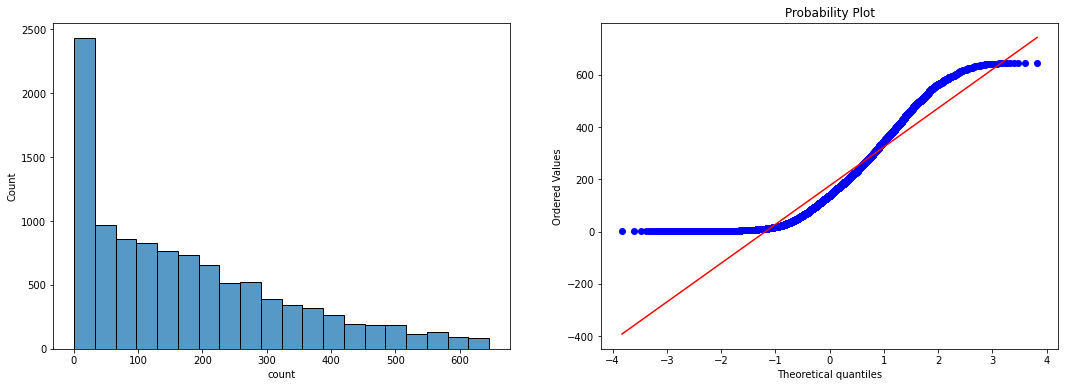




Variance check between sample1 and sample2 and sample3 LeveneResult(statistic=5.911558891001413, pvalue=0.002869023521321527)


In [56]:
# Here we will remove points above  (Q3 + 1.5*IQR) as outliers
q75, q25 = np.percentile(df['count'], [75 ,25])
new_df = df[df['count']<(q75+(1.5*(q75-q25)))]
print('Difference in records between original df and after removing outliers: ', df.shape[0] - new_df.shape[0])
print(f"Shapiro Wilk test for normality check for count variable, gives test_statistics and p_val of: {stats.shapiro(new_df['count'])}")
print('\n\n')


# Normality check of the population 
fig, ax = plt.subplots(1, 2, figsize=(18,6))
sns.histplot(data=new_df['count'], bins=20, ax=ax[0])
prob = stats.probplot(new_df['count'], dist=stats.norm, plot=ax[1])
plt.show()
print('\n\n')


# Variance check of he samples,

# we will create 3 samples, In each sample we will take 200 random data points
# sample1: samples of bike rent count for weather1 
# sample2: samples of bike rent count for weather2
# sample3: samples of bike rent count for weather3

# random state to generate same random samples every time we run the code 
random_state = 42

sample1 = new_df[new_df['weather']==1]['count'].sample(n=200, random_state=random_state)
sample2 = new_df[new_df['weather']==2]['count'].sample(n=200, random_state=random_state)
sample3 = new_df[new_df['weather']==3]['count'].sample(n=200, random_state=random_state)

print(f"Variance check between sample1 and sample2 and sample3 {stats.levene(sample1, sample2, sample3)}")

In [57]:
# Now we will start with our ANOVA test 
from scipy.stats import f_oneway

# We will use one way Anova as we have only one dependent variable
f_oneway(sample1, sample2, sample3)

F_onewayResult(statistic=14.109869455317735, pvalue=1.029396388733257e-06)

### Anova test for different seasons to check if bikes rent dependent on seasons.

---

Assumptions:
1. Each group sample is drawn from a normally distributed population: 
<br>
We will check if the feature "count" is normally disributed using Shapiro Wilk test, after removing outliers ofcourse.
<br>
We see that Shapiro Wilk test is failing badly(with P-val=0). Also histogram and QQ plot shows that data is clearly right skewed. (Still we will go ahead with our Anova analysis as mentioned in the problem statement). However when the sample size is very large sometimes non Gaussian Disributed data also works well.
<br>
Also here we can not transofrm the count variable to log or box-cox to get normal distribution, because tansforming will change the variance of the dataset, hence the Anova results will not be accurate.
<br>
<br>
2. All populations have a common variance: 
<br>
Levene test of equal variance also fails with a P-val of 8.546133027189883e-06.
<br>
<br>
3. All samples are drawn independently of each other: 
<br>
This we are sure of that each sample is drawn randomly from others.
<br>

---
Null hypothesis(H0): mu1 = mu2 = mu3 = mu4 (Means of all the samples for different seasons types are same.)
<br>
Alternate hypothesis(H0): Sample means are not same.
<br>
<br>
<br>

Conclusion:
<br>
We found that P-val of Anova test is 1.974306988372236e-07. Which is way less than 0.05 with 95% confidence. So we can say that means of 4 samples are not same. They are different. Which also states that we will reject Null hypothesis and accept Alternate hypothesis.
<br>
We also saw in the visual analysis section that bike rent mean of season3 > season2 > season4 > season1 .

Difference in records between original df and after removing outliers:  303
Shapiro Wilk test for normality check for count variable, gives test_statistics and p_val of: (0.9020087718963623, 0.0)





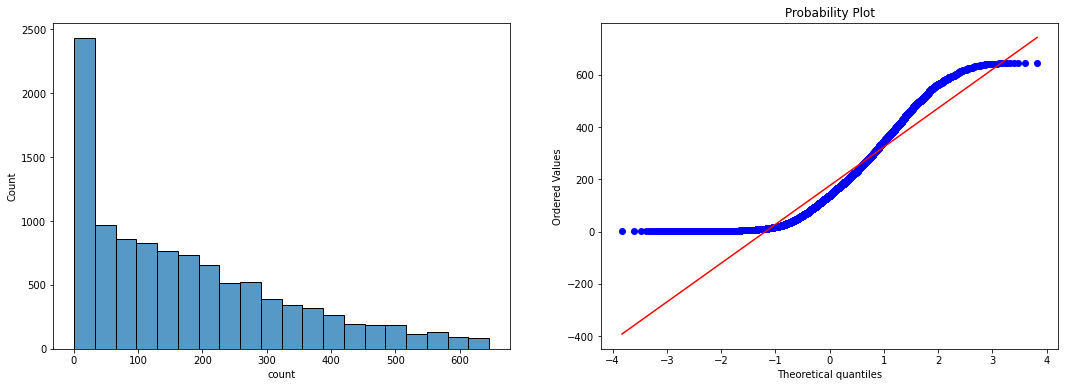




Variance check between sample1, sample2, sample3 and sample4 LeveneResult(statistic=8.882504910078303, pvalue=8.546133027189883e-06)


In [59]:
# Here we will remove points above  (Q3 + 1.5*IQR) as outliers
q75, q25 = np.percentile(df['count'], [75 ,25])
new_df = df[df['count']<(q75+(1.5*(q75-q25)))]
print('Difference in records between original df and after removing outliers: ', df.shape[0] - new_df.shape[0])
print(f"Shapiro Wilk test for normality check for count variable, gives test_statistics and p_val of: {stats.shapiro(new_df['count'])}")
print('\n\n')


# Normality check of the population 
fig, ax = plt.subplots(1, 2, figsize=(18,6))
sns.histplot(data=new_df['count'], bins=20, ax=ax[0])
prob = stats.probplot(new_df['count'], dist=stats.norm, plot=ax[1])
plt.show()
print('\n\n')


# Variance check of he samples,

# we will create 3 samples, In each sample we will take 200 random data points
# sample1: samples of bike rent count for weather1 
# sample2: samples of bike rent count for weather2
# sample3: samples of bike rent count for weather3

# random state to generate same random samples every time we run the code 
random_state = 42

sample1 = new_df[new_df['season']==1]['count'].sample(n=200, random_state=random_state)
sample2 = new_df[new_df['season']==2]['count'].sample(n=200, random_state=random_state)
sample3 = new_df[new_df['season']==3]['count'].sample(n=200, random_state=random_state)
sample4 = new_df[new_df['season']==4]['count'].sample(n=200, random_state=random_state)

print(f"Variance check between sample1, sample2, sample3 and sample4 {stats.levene(sample1, sample2, sample3, sample4)}")

In [60]:
# Now we will start with our ANOVA test 
from scipy.stats import f_oneway

# We will use one way Anova as we have only one dependent variable
f_oneway(sample1, sample2, sample3, sample4)

F_onewayResult(statistic=11.573953861101707, pvalue=1.974306988372236e-07)